In [1]:
 """ Calibration individual color copepod images 

Usage:
======
    1. Read images and check image information - print 32 images randomly [X]
    2. Intercalibrate images and save them - print 32 images randomly [X]
    3. Explore calibration results on image examples [X]
"""

__authors__ = ("Laure Vilgrain", "Jean-Olivier Irisson", "Simon-Martin Schröder")
__contact__ = ("laure.vilgrain@imev-mer.fr", "irisson@normalesup.org", "sms@informatik.uni-kiel.de")
__version__ = "1.0.0"
__date__ = "04-2021" 

In [3]:
import pandas as pd
import numpy as np
import csv
import xarray as xr
import os
import statistics as stat
from matplotlib import pyplot as plt
import copy
import random
import pickle
import sys
import time
import gc
import shutil

from skimage.io import imread
from skimage.color.colorconv import separate_stains, gray_from_rgb, yuv_from_rgb, yiq_from_rgb, rgb_from_hed, hed_from_rgb
from scipy import linalg
from skimage import io, data, color, exposure, feature, morphology, measure
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu
from matplotlib.colors import hex2color, rgb2hex
import colour
from colour.plotting import plot_single_colour_swatch, ColourSwatch

In [4]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## What you need to do before running this code: 
1. Follow the best guidelines to take copepod's pictures
2. Check that all your images are backed up at several locations
3. Give informative names to images (i.e. station, date, depth, etc)
4. Find the path to the initial directory where all your images are
5. Know the pixel pitch of your images in millimeters or micrometres

In [5]:
# put here the path to the directory with all raw images of copepods
initial_dir = "../imgs_dataset/"

## 1. Read images and check image information

### Create a folder for Original images

In [6]:
#we create a directory named "1.Original" inside to put all the raw images and differentiate them from processed ones 
original_dir = initial_dir + "1.Original/"

# create the directory
if not os.path.exists(original_dir):
    os.makedirs(original_dir)

In [7]:
# Allowed image extensions (in lowercase)
allowed_extensions = ('.jpg', '.png', '.tiff', '.tif')

# Check if both directories exist
if not os.path.exists(initial_dir ):
    print(f"The source folder '{initial_dir}' does not exist.")
elif not os.path.exists(original_dir):
    print(f"The destination folder '{original_dir}' does not exist.")
else:
    # Loop through all files in the source folder
    for filename in os.listdir(initial_dir):
        file_path = os.path.join(initial_dir, filename)

        # Check if it's a file and has an allowed image extension
        if os.path.isfile(file_path) and filename.lower().endswith(allowed_extensions):
            # Move the file to the destination folder
            shutil.move(file_path, os.path.join(original_dir, filename))
            print(f"{filename} moved to {original_dir}")

    print("Image transfer complete.")

Image transfer complete.


### Check image information (size, pixels, etc). 

the size of one pixel in 2018 is 0.0021929824561403508 mm = 2.1929824561403506 μm
the size of one pixel in 2019 is 0.002717391304347826 mm = 2.717391304347826 μm
The total length of one image is 2560 pixels. The total height is 1920 pixels.
The total length of one image is 5.614035087719298 mm


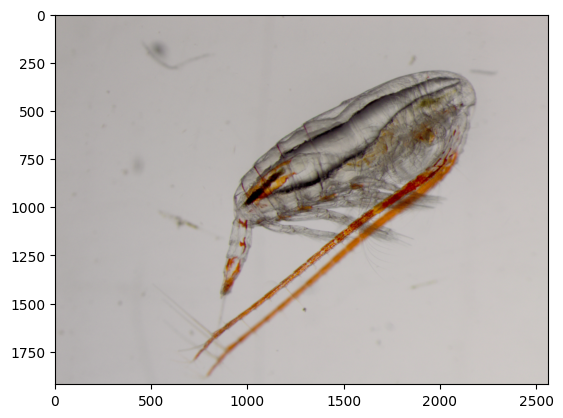

In [8]:
# Store and sort original image names
imgs_names = os.listdir(original_dir) # all images to read
imgs_names.sort() # sort images to visualize them in the same order

# Image total size
img_ex = io.imread(original_dir + imgs_names[5])
plt.imshow(img_ex)
img_length = img_ex.shape[1]
img_height = img_ex.shape[0]
img_pixel_number = img_ex.size

# Pixel pitch 
# here you need to know what is the pitch of pixel
# For this original dataset: in 2018 it was 456 pixels per 1mm, in 2019 it was 368 pixels per 1 mm which was obtained from ImageJ with a scale taken in photo"
pixel_2018_mm = 1/456
pixel_2018_um = pixel_2018_mm*1000

pixel_2019_mm = 1/368
pixel_2019_um = pixel_2019_mm*1000

print('the size of one pixel in 2018 is', pixel_2018_mm,'mm =', pixel_2018_um, 'μm')
print('the size of one pixel in 2019 is', pixel_2019_mm,'mm =', pixel_2019_um, 'μm')

# Image total length
print('The total length of one image is', img_length, 'pixels. The total height is', img_height,'pixels.')
print('The total length of one image is', img_length * pixel_2018_mm, 'mm')

### Store original RGB median values of images
Median values of background RGB are used to calibrate RGB values of the entire image with the principle of the "grey world" algorithm -> all RGB channels from all images are centered arround a median value of RGB.  

In [9]:
# TODO : check if we can optimize this because it is really long
original_RGB = []
RGB_median_list = [] # prepare a list to save median RGB values of images
size_list = []

# DO: add a condition on file types to read (.tiff, .jpg)
valid_extensions = [".tif", ".tiff", ".jpg", ".jpeg", ".png"]
imgs_names = [img for img in imgs_names if any(img.endswith(ext) for ext in valid_extensions)]

#Image analysis 
for i in range(0, len(imgs_names)): 
    filename = "../imgs_dataset/1.Original/" + imgs_names[i]
    img = io.imread(filename)
    RGB_median_list.append(np.median(img))# stock the RGB median values in a list
    original_RGB.append(np.mean(img, axis=(0,1)))# stock the RGB calibrated values in a list

In [10]:
print("Average original RGB value:", np.mean(original_RGB),", standard deviation:", np.std(original_RGB))
#print("List of RGB medians: ", RGB_median_list) 
print("Average median RGB value of images is", np.mean(RGB_median_list), "and represent typical color of the background. We will use this value to calibrate all images.")

Average original RGB value: 172.311636501 , standard deviation: 17.6383846957
Average median RGB value of images is 178.902718169 and represent typical color of the background. We will use this value to calibrate all images.


### Visualize a random sample of images with the RGB values

In [14]:
# Print a selection of original images
imgs_sample = random.sample(imgs_names,32)

Original images


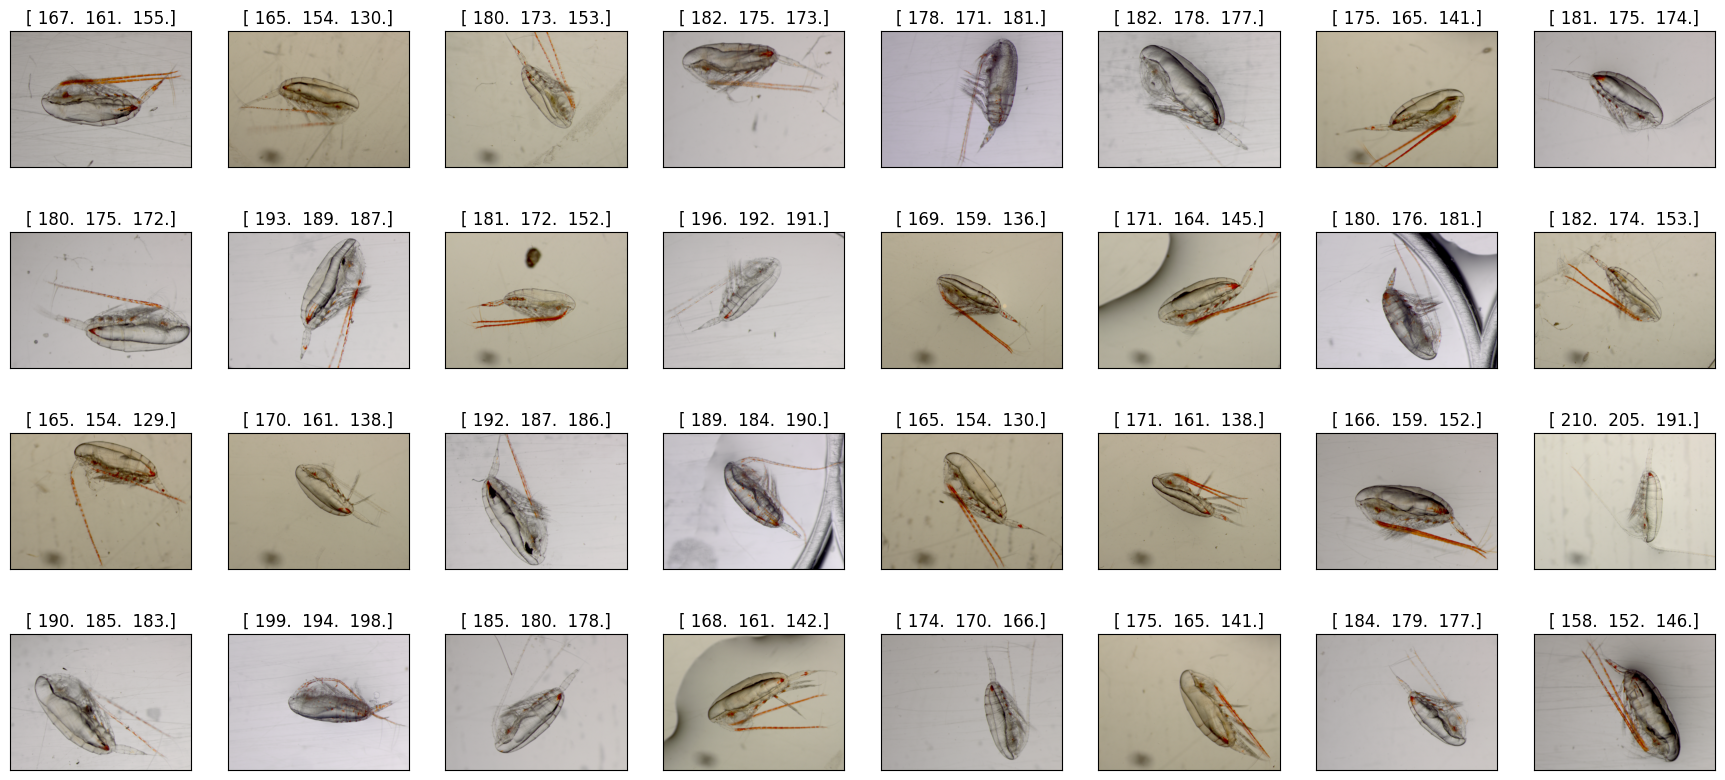

In [16]:
print("Original images")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, columns*rows): 
    filename = original_dir + imgs_sample[i]
    img = io.imread(filename)
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(np.around(np.mean(img, axis=(0,1))))
    plt.imshow(img)
plt.show()

## 2. Intercalibrate images and save them

### Intercalibrate and save

In [12]:
# create a folder for calibrated images
calibrated_dir = initial_dir + "2.Calibrated/"
if not os.path.exists(calibrated_dir):
    os.makedirs(calibrated_dir)

In [19]:
if not os.listdir(calibrated_dir): #if the folder is not already full
    for i in range(0, len(imgs_names)): 
        filename = original_dir + imgs_names[i]
        img = io.imread(filename)
        # compute median intensity per channel
        med_r = np.median(img[:,:,0])
        med_g = np.median(img[:,:,1])
        med_b = np.median(img[:,:,2])
        
        # convert all channels to have similar average intensities on the original image and between images
        img_calib = copy.copy(img)
        img_calib[:,:,0] = np.minimum(img[:,:,0] / med_r * np.mean(RGB_median_list), 255) # NB: check that this stays in [0,255] = [black, white]
        img_calib[:,:,1] = np.minimum(img[:,:,1] / med_g * np.mean(RGB_median_list), 255)
        img_calib[:,:,2] = np.minimum(img[:,:,2] / med_b * np.mean(RGB_median_list), 255)
        io.imsave(calibrated_dir + imgs_names[i], img_calib)
    print("Average final RGB value:", np.mean(final_RGB), ", standard deviation:", np.std(final_RGB))

In [66]:
# Check how RGB values had changed 
final_RGB = [] #list with final images arrays

for i in range(0, len(imgs_names)): 
    img_calib_filename = calibrated_dir + imgs_names[i]
    img_calib = io.imread(img_calib_filename)
    final_RGB.append(np.mean(img_calib, axis=(0,1))) # stock the RGB calibrated values in a list
print("Average final RGB value:", np.mean(final_RGB), ", standard deviation:", np.std(final_RGB))

Average final RGB value: 171.857360255 , standard deviation: 3.43230237014


### Visualize

Calibrated images


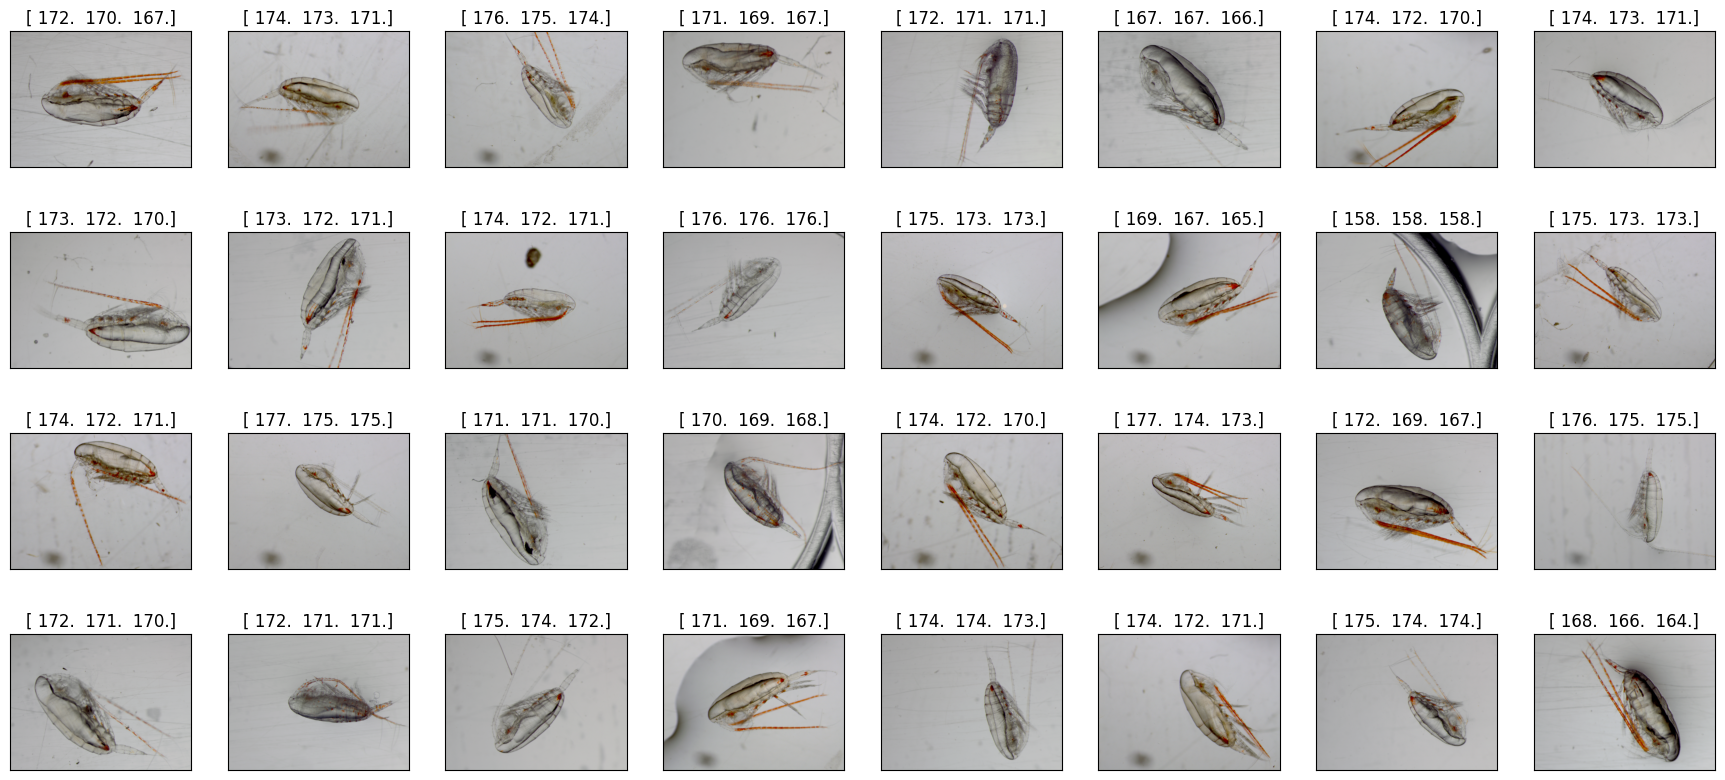

In [20]:
print("Calibrated images")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, columns*rows): 
    filename = calibrated_dir + imgs_sample[i]
    img = io.imread(filename)
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(np.around(np.mean(img, axis=(0,1))))
    plt.imshow(img)
plt.show()

## 3. Explore calibration results on few image examples
-> we can manipulate them to see the effect before/after calibration </br>
-> we can look at their RGB distribution before/after calibration

In [22]:
# List of all calibrated images
imgs_calib_list = os.listdir(calibrated_dir) # for now, we are taking calibrated images with the first calibration method 
imgs_calib_list.sort() # sort images to visualize them in the same order

In [54]:
# Original
img1_ori_path = original_dir + imgs_calib_list[0]
img2_ori_path = original_dir + imgs_calib_list[400]
img3_ori_path  = original_dir + imgs_calib_list[698]

# Calibrated
img1_cali_path = calibrated_dir + imgs_calib_list[0]
img2_cali_path = calibrated_dir + imgs_calib_list[400]
img3_cali_path  = calibrated_dir + imgs_calib_list[698]

'../imgs_dataset/2.Calibrated/2018_G_p86_1.tif'

**Image 1**

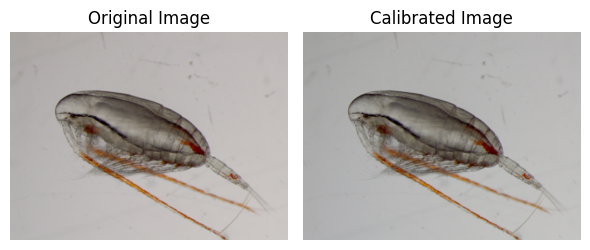

In [49]:
# Plot histogram of RGB values in one image
img1_ori = io.imread(img1_ori_path)
img1_cali = io.imread(img1_cali_path)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img1_ori)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(img1_cali)
axes[1].set_title("Calibrated Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

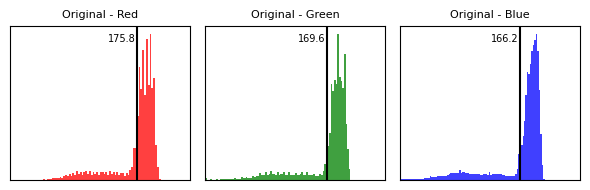

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

colors = ['r', 'g', 'b']
channel_names = ['Red', 'Green', 'Blue']

for i, ax in enumerate(axes):
    channel_data = img1_ori[:, :, i].ravel()
    mean_val = np.around(np.mean(channel_data), 1)  # valeur arrondie à 1 décimale
    
    ax.hist(channel_data, bins=100, facecolor=colors[i], alpha=0.75)
    ax.axvline(x=mean_val, color='black')

    # Ajouter le texte juste à droite de la ligne verticale
    ax.text(mean_val - 40, ax.get_ylim()[1]*0.9, f'{mean_val}', color='black', fontsize=7)

    ax.set_xlim(0, 250)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Original - {channel_names[i]}', fontsize=8)

plt.tight_layout()
plt.show()

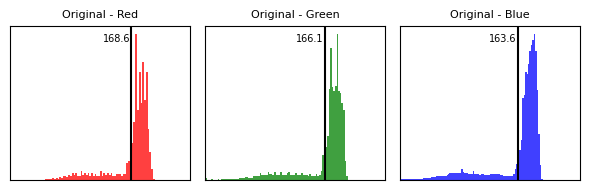

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

colors = ['r', 'g', 'b']
channel_names = ['Red', 'Green', 'Blue']

for i, ax in enumerate(axes):
    channel_data = img1_cali[:, :, i].ravel()
    mean_val = np.around(np.mean(channel_data), 1)  # valeur arrondie à 1 décimale
    
    ax.hist(channel_data, bins=100, facecolor=colors[i], alpha=0.75)
    ax.axvline(x=mean_val, color='black')

    # Ajouter le texte juste à droite de la ligne verticale
    ax.text(mean_val - 40, ax.get_ylim()[1]*0.9, f'{mean_val}', color='black', fontsize=7)

    ax.set_xlim(0, 250)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Original - {channel_names[i]}', fontsize=8)

plt.tight_layout()
plt.show()

**Image 2**

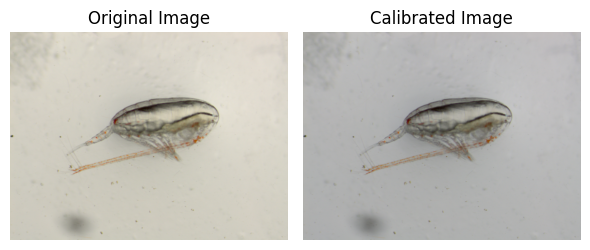

In [55]:
# Plot histogram of RGB values in one image
img2_ori = io.imread(img2_ori_path)
img2_cali = io.imread(img2_cali_path)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img2_ori)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(img2_cali)
axes[1].set_title("Calibrated Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

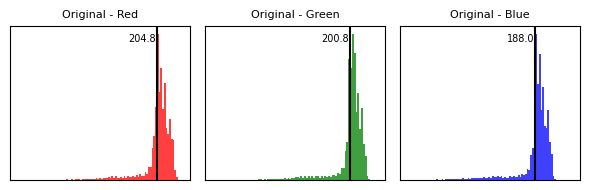

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

colors = ['r', 'g', 'b']
channel_names = ['Red', 'Green', 'Blue']

for i, ax in enumerate(axes):
    channel_data = img2_ori[:, :, i].ravel()
    mean_val = np.around(np.mean(channel_data), 1)  # valeur arrondie à 1 décimale
    
    ax.hist(channel_data, bins=100, facecolor=colors[i], alpha=0.75)
    ax.axvline(x=mean_val, color='black')

    # Ajouter le texte juste à droite de la ligne verticale
    ax.text(mean_val - 40, ax.get_ylim()[1]*0.9, f'{mean_val}', color='black', fontsize=7)

    ax.set_xlim(0, 250)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Original - {channel_names[i]}', fontsize=8)

plt.tight_layout()
plt.show()

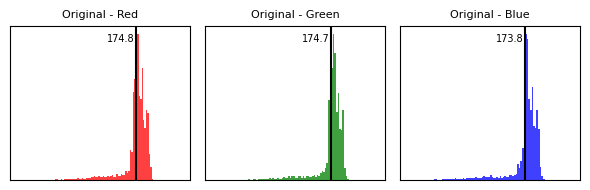

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

colors = ['r', 'g', 'b']
channel_names = ['Red', 'Green', 'Blue']

for i, ax in enumerate(axes):
    channel_data = img2_cali[:, :, i].ravel()
    mean_val = np.around(np.mean(channel_data), 1)  # valeur arrondie à 1 décimale
    
    ax.hist(channel_data, bins=100, facecolor=colors[i], alpha=0.75)
    ax.axvline(x=mean_val, color='black')

    # Ajouter le texte juste à droite de la ligne verticale
    ax.text(mean_val - 40, ax.get_ylim()[1]*0.9, f'{mean_val}', color='black', fontsize=7)

    ax.set_xlim(0, 250)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Original - {channel_names[i]}', fontsize=8)

plt.tight_layout()
plt.show()

**Image 3**

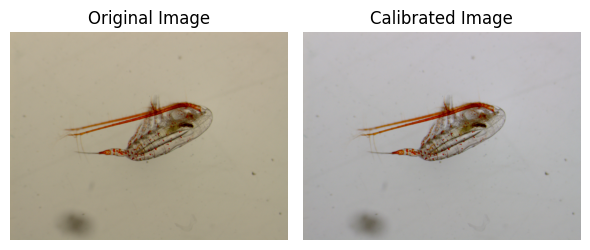

In [53]:
# Plot histogram of RGB values in one image
img3_ori = io.imread(img3_ori_path)
img3_cali = io.imread(img3_cali_path)

# Plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img3_ori)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(img3_cali)
axes[1].set_title("Calibrated Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

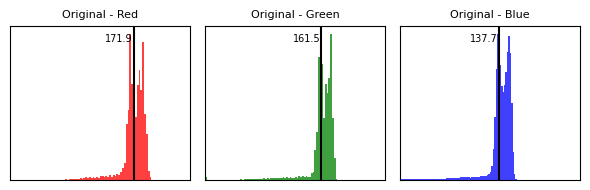

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

colors = ['r', 'g', 'b']
channel_names = ['Red', 'Green', 'Blue']

for i, ax in enumerate(axes):
    channel_data = img3_ori[:, :, i].ravel()
    mean_val = np.around(np.mean(channel_data), 1)  # valeur arrondie à 1 décimale
    
    ax.hist(channel_data, bins=100, facecolor=colors[i], alpha=0.75)
    ax.axvline(x=mean_val, color='black')

    # Ajouter le texte juste à droite de la ligne verticale
    ax.text(mean_val - 40, ax.get_ylim()[1]*0.9, f'{mean_val}', color='black', fontsize=7)

    ax.set_xlim(0, 250)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Original - {channel_names[i]}', fontsize=8)

plt.tight_layout()
plt.show()

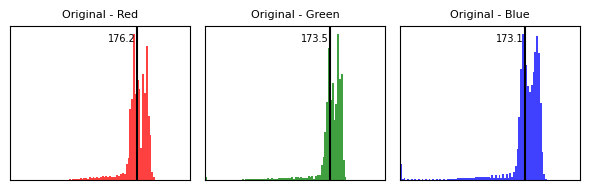

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

colors = ['r', 'g', 'b']
channel_names = ['Red', 'Green', 'Blue']

for i, ax in enumerate(axes):
    channel_data = img3_cali[:, :, i].ravel()
    mean_val = np.around(np.mean(channel_data), 1)  # valeur arrondie à 1 décimale
    
    ax.hist(channel_data, bins=100, facecolor=colors[i], alpha=0.75)
    ax.axvline(x=mean_val, color='black')

    # Ajouter le texte juste à droite de la ligne verticale
    ax.text(mean_val - 40, ax.get_ylim()[1]*0.9, f'{mean_val}', color='black', fontsize=7)

    ax.set_xlim(0, 250)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Original - {channel_names[i]}', fontsize=8)

plt.tight_layout()
plt.show()

## Sumarise key values to export from this code that will be used in a code for new images

There is mostly the mean_values of median values (= a pixel of the background): 
computed with **np.mean(RGB_median_list) = 178.902718169**.
I am not sure we need to keep other things in this code (such as the lists) because they are used only once. But it is good to remember that the variability of RGB was originally: <br/>
**Average original RGB value: 172.311636501, standard deviation: 17.6383846957**<br/>
and change into: <br/> 
**Average original RGB value: 171.857360255, standard deviation: 3.43230237014**<br/>
-> all RGB values are centered and variability is reduced



## Check memory

In [69]:
# list of all objects in the environment
objs = [(var, sys.getsizeof(val)) for var, val in globals().items() if not var.startswith("__")]

# print them within a dataFrame, sorted by decreasing size par 
objects_sizes = pd.DataFrame(objs, columns=['Variable', 'Size (octets)']).sort_values(by='Size (octets)', ascending=False)
objects_sizes


def format_size(size):
    for unit in ['o', 'Ko', 'Mo', 'Go']:
        if size < 1024:
            return f"{size:.1f} {unit}"
        size /= 1024
    return f"{size:.1f} To"

objects_sizes['Readable size'] = objects_sizes['Size (octets)'].apply(format_size)
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')
objects_sizes[['Variable', 'Readable size']]

,Variable,Readable size
110,channel_data,4.7 Mo
145,objects_sizes,22.7 Ko
9,_,21.3 Ko
157,_67,21.3 Ko
154,_65,20.7 Ko
...,...,...
79,rows,28.0 o
66,pixel_2019_um,24.0 o
65,pixel_2019_mm,24.0 o
64,pixel_2018_um,24.0 o


In [68]:
def delete_img_objets():
    names_to_delete = [name for name in globals() if 'img' in name and name != 'delete_objects_with_img']
    for name in names_to_delete:
        del globals()[name]

delete_img_objets()